In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from fim import apriori as fim_apriori
from gsp import apriori as gsp_apriori

# Task 4: Frequent Pattern mining and Association Rule Mining

In [2]:
df_geo = pd.read_csv('../geography.csv', sep=',', index_col=0)
df_ram = pd.read_csv('../ram.csv', sep=',', index_col=0)

# Processed dataset split for VCS purposes
df_sales_part1 = pd.read_csv('../DM_14_TASK1/task1-df_sales-part1.csv', sep=',', index_col=0) #The dataset doesn't have a column name. This causes the error.
df_sales_part2 = pd.read_csv('../DM_14_TASK1/task1-df_sales-part2.csv', sep=',', index_col=0)
df_sales = df_sales_part1.append(df_sales_part2)

df_time = pd.read_csv('../time.csv', sep=',', index_col=0)
df_vendor = pd.read_csv('../vendor.csv', sep=',', index_col=0)

/home/avenger/.local/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
#Merge data into a single dataframe
df_sales_merged = df_sales[["Id", "ram_code"]].join(df_ram, on="ram_code", rsuffix="_ram")
df_sales_merged["time_code"] = df_sales["time_code"]
df_sales_merged = df_sales_merged.join(df_time.set_index("time_code"), on="time_code")
df_sales_merged["geo_code"] = df_sales["geo_code"]
df_sales_merged = df_sales_merged.join(df_geo.set_index("geo_code"), on="geo_code")
df_sales_merged["vendor_code"] = df_sales["vendor_code"]
df_sales_merged = df_sales_merged.join(df_vendor.set_index("vendor_code"), on="vendor_code", rsuffix="_vendor")
df_sales_merged = df_sales_merged.join(df_sales[["sales_uds", "sales_currency"]])

#Make the ram_code feature a string in order to use it with gsp
df_sales_merged.loc[:, "ram_code"] = df_sales_merged.loc[:, "ram_code"].astype(int).apply(str)

In [4]:
df_sales_merged.head()

,Id,ram_code,brand,name,memory,memory_type,clock,time_code,year,month,...,week,geo_code,continent,country,region,currency,vendor_code,name_vendor,sales_uds,sales_currency
2602347,3719,1,ADATA,Adata,0.5,DDR,400,20130322,2013,3,...,12,25,Europe,Germany,north rhine-westphalla,EUR,32,geizhals_unknown,13.749032,10.65
2602348,3719,1,ADATA,Adata,0.5,DDR,400,20130323,2013,3,...,12,18,Europe,Germany,berlin,EUR,32,geizhals_unknown,13.828708,10.65
2602349,3719,1,ADATA,Adata,0.5,DDR,400,20130326,2013,3,...,13,28,Europe,Germany,saxony,EUR,32,geizhals_unknown,13.694297,10.65
2602350,3719,1,ADATA,Adata,0.5,DDR,400,20130327,2013,3,...,13,25,Europe,Germany,north rhine-westphalla,EUR,32,geizhals_unknown,13.690530,10.65
2602351,3719,1,ADATA,Adata,0.5,DDR,400,20130328,2013,3,...,13,27,Europe,Germany,saarland,EUR,32,geizhals_unknown,13.605216,10.65


## Dataframe pre-processing  
Here we are interested in making the sales dataframe more suitable for our analyses.

### Feature removal

In [5]:
feat_to_drop = ["Id", "geo_code", "vendor_code", "sales_currency", "year", "month", "day", "week"]

df_sales_proc = df_sales_merged.drop(feat_to_drop, axis=1)
df_sales_proc.head()

,ram_code,brand,name,memory,memory_type,clock,time_code,continent,country,region,currency,name_vendor,sales_uds
2602347,1,ADATA,Adata,0.5,DDR,400,20130322,Europe,Germany,north rhine-westphalla,EUR,geizhals_unknown,13.749032
2602348,1,ADATA,Adata,0.5,DDR,400,20130323,Europe,Germany,berlin,EUR,geizhals_unknown,13.828708
2602349,1,ADATA,Adata,0.5,DDR,400,20130326,Europe,Germany,saxony,EUR,geizhals_unknown,13.694297
2602350,1,ADATA,Adata,0.5,DDR,400,20130327,Europe,Germany,north rhine-westphalla,EUR,geizhals_unknown,13.690530
2602351,1,ADATA,Adata,0.5,DDR,400,20130328,Europe,Germany,saarland,EUR,geizhals_unknown,13.605216


Here we removed some features that are either redundant or do not carry useful information for this task.

### time_code type adjustment

In [6]:
df_sales_proc["time_code"] = pd.to_datetime(df_sales_proc["time_code"], format="%Y%m%d")
df_sales_proc["time_code"]

2602347   2013-03-22
2602348   2013-03-23
2602349   2013-03-26
2602350   2013-03-27
2602351   2013-03-28
             ...    
6014673   2017-03-10
6014674   2017-05-05
6014675   2017-05-10
6014676   2017-05-11
6014677   2017-06-08
Name: time_code, Length: 3342700, dtype: datetime64[ns]

We will use the timecodes to group the frequent sequences by smaller units of time compared to the ones available.

### Feature discretisation
We are interested in discretising memory, clock and the sales value using equal-width binning.

#### Memory

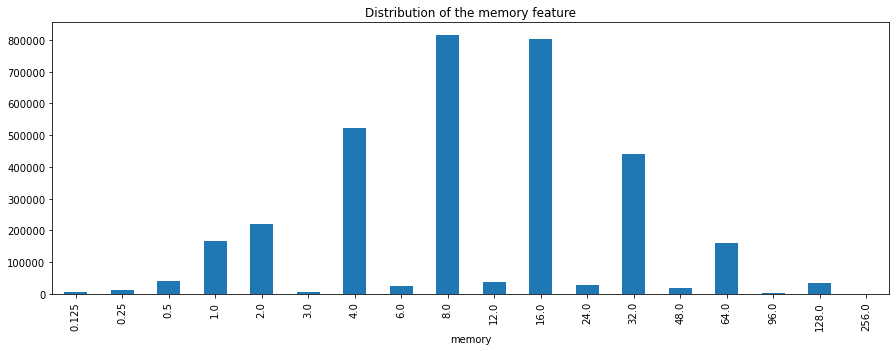

In [7]:
plt.figure(figsize=(15,5))
plt.title("Distribution of the memory feature")
df_sales_proc.groupby("memory").size().plot(kind="bar")
plt.show()

The distribution of memory has an almost symmetric distribution, we can use this to define different bins.  
We will consider the ranges [0,4], [6,8], [12,16], [24,32] and [48,256].  

This choice is in part due to the distribution above and in part based on our knowledge of sizes of ram found in the commercial products.  
In low cost/power/old products usually the amount of ram doesn't exceed 4 GB, mid-range can go up to 8 GB and so on.  
Regarding the last range it reflects the fact that amount of memory is usually used for servers/high-end workstations, therefore they belong to a class of their own.

In [8]:
bins = pd.IntervalIndex.from_tuples([(0, 4), (6, 8), (12, 16), (24, 32), (48, 256)], closed="both")

df_sales_proc.loc[:, "memory"] = pd.cut(df_sales_proc['memory'].astype(int), bins, right=False)
df_sales_proc.loc[:, "memory"] = df_sales_proc["memory"].astype(str) + '_mem'

#### Clock

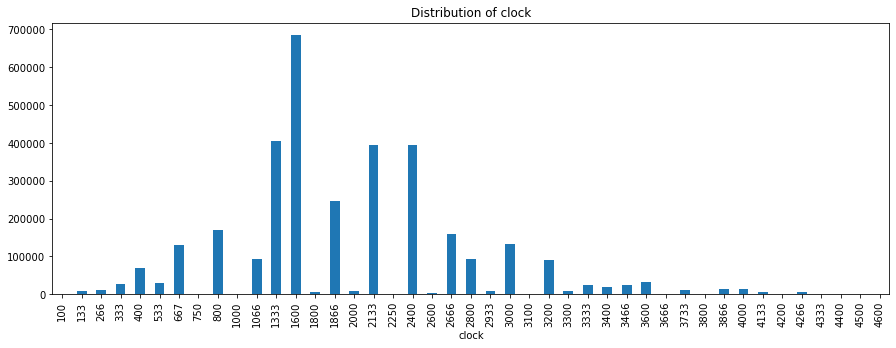

In [9]:
plt.figure(figsize=(15,5))
plt.title("Distribution of clock")
df_sales_proc.groupby(["clock"]).size().plot(kind="bar")
plt.show()

In [10]:
bins = pd.IntervalIndex.from_tuples([(100, 1333), (1600, 1800), (1866, 2250), (2400, 3200), (3300, 4600)], closed="both")

df_sales_proc.loc[:, "clock"] = pd.cut(df_sales_proc['clock'].astype(int), bins, right=False)
df_sales_proc.loc[:, "clock"] = df_sales_proc["clock"].astype(str) + '_clock'

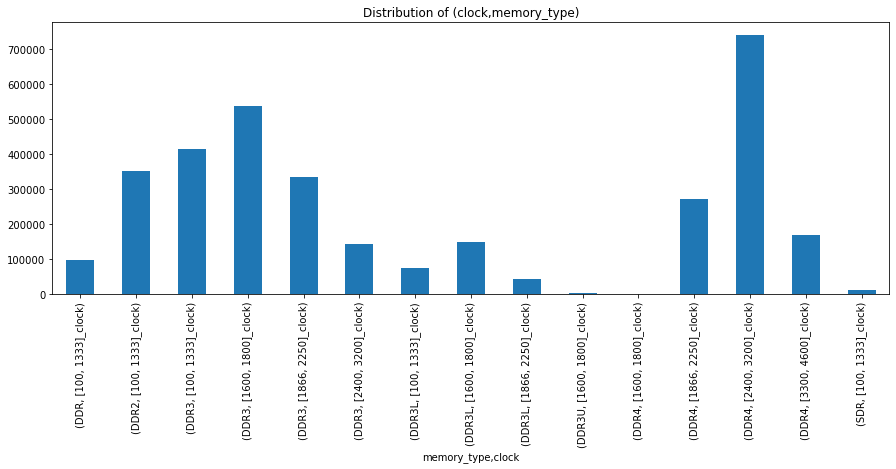

In [11]:
plt.figure(figsize=(15,5))
plt.title("Distribution of (clock,memory_type)")
df_sales_proc.groupby(["memory_type", "clock"]).size().plot(kind="bar")
plt.show()

Again we defined interval roughly based on a equal-frequency binning approach and what can be considered a low-end/high-end product.  
Note that this is only a rough approximation, for the purpouse of discretising we are ignoring the memory_type even though the distribution of the clock is not uniform across the DDR types.

#### Sales

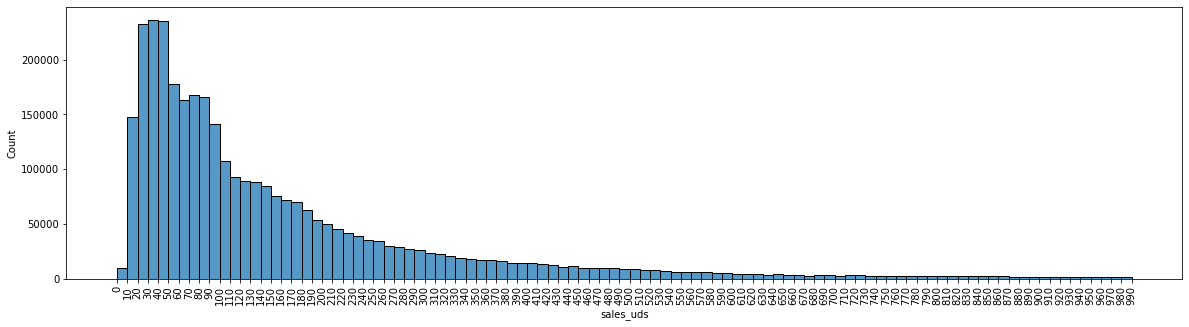

In [12]:
bins = range(0, 1000, 10)

plt.figure(figsize=(20,5))
sn.histplot(df_sales_proc["sales_uds"], bins=bins)
plt.xticks(bins, rotation=90)
plt.show()

In this case we will split the data based on the frequency of the entries using quantiles.

In [13]:
pd.qcut(df_sales_proc["sales_uds"].astype(int), 10).unique()

[(0.999, 27.0], (27.0, 41.0], (41.0, 57.0], (57.0, 78.0], (78.0, 99.0], (99.0, 134.0], (134.0, 177.0], (177.0, 246.0], (246.0, 395.0], (395.0, 10630.0]]
Categories (10, interval[float64]): [(0.999, 27.0] < (27.0, 41.0] < (41.0, 57.0] < (57.0, 78.0] ... (134.0, 177.0] < (177.0, 246.0] < (246.0, 395.0] < (395.0, 10630.0]]

In [14]:
df_sales_proc.loc[:, "sales_uds"] = pd.qcut(df_sales_proc["sales_uds"].astype(int), 10)

df_sales_proc.loc[:, "sales_uds"] = df_sales_proc["sales_uds"].astype(str) + '_sales_uds'

#### Results

In [15]:
df_sales_proc.head()

,ram_code,brand,name,memory,memory_type,clock,time_code,continent,country,region,currency,name_vendor,sales_uds
2602347,1,ADATA,Adata,"[0, 4]_mem",DDR,"[100, 1333]_clock",2013-03-22,Europe,Germany,north rhine-westphalla,EUR,geizhals_unknown,"(0.999, 27.0]_sales_uds"
2602348,1,ADATA,Adata,"[0, 4]_mem",DDR,"[100, 1333]_clock",2013-03-23,Europe,Germany,berlin,EUR,geizhals_unknown,"(0.999, 27.0]_sales_uds"
2602349,1,ADATA,Adata,"[0, 4]_mem",DDR,"[100, 1333]_clock",2013-03-26,Europe,Germany,saxony,EUR,geizhals_unknown,"(0.999, 27.0]_sales_uds"
2602350,1,ADATA,Adata,"[0, 4]_mem",DDR,"[100, 1333]_clock",2013-03-27,Europe,Germany,north rhine-westphalla,EUR,geizhals_unknown,"(0.999, 27.0]_sales_uds"
2602351,1,ADATA,Adata,"[0, 4]_mem",DDR,"[100, 1333]_clock",2013-03-28,Europe,Germany,saarland,EUR,geizhals_unknown,"(0.999, 27.0]_sales_uds"


## Association rules

### Vendor-level associations
Due to memory constraints we are forced to apply a stratified (with respect to the vendor) random sampling to the sales dataset.

In [16]:
df_assoc_sampled = df_sales_proc.groupby(["name_vendor"]).sample(frac=0.001, random_state=0)
num_trans_assoc = df_assoc_sampled.shape[0]

print(f"Number of transactions sampled: {num_trans_assoc}")
df_assoc_sampled.head()

Number of transactions sampled: 3341


,ram_code,brand,name,memory,memory_type,clock,time_code,continent,country,region,currency,name_vendor,sales_uds
3528941,854,CRUCIAL,Crucial,"[0, 4]_mem",DDR4,"[1866, 2250]_clock",2017-10-22,Oceania,New Zeland,south island-southern,NZD,1stWave Technologies,"(41.0, 57.0]_sales_uds"
5089507,2201,KINGSTON,Kingston Hyperx Fury,"[6, 8]_mem",DDR4,"[2400, 3200]_clock",2017-08-05,Europe,Germany,mecklenburg-vorpommern,EUR,ARLT,"(99.0, 134.0]_sales_uds"
3538678,857,CRUCIAL,Crucial,"[6, 8]_mem",DDR4,"[1866, 2250]_clock",2017-10-04,America,United States of America,north-east usa,USD,Adorama,"(99.0, 134.0]_sales_uds"
3452453,804,CRUCIAL,Crucial,"[6, 8]_mem",DDR3,"[1600, 1800]_clock",2017-02-04,America,United States of America,north-east usa,USD,Adorama,"(78.0, 99.0]_sales_uds"
3556244,861,CRUCIAL,Crucial,"[12, 16]_mem",DDR4,"[2400, 3200]_clock",2017-10-10,America,United States of America,mid-atalntic,USD,Adorama,"(134.0, 177.0]_sales_uds"


In [17]:
trans_ram_code = df_assoc_sampled.groupby(["name_vendor"])["ram_code"].apply(list)
trans_ram_code.head()

name_vendor
1stWave Technologies                                                [854]
ARLT                                                               [2201]
Adorama                                                   [857, 804, 861]
Alternate                                               [1297, 1485, 440]
Alza                    [679, 973, 2189, 3234, 2188, 2046, 857, 1601, ...
Name: ram_code, dtype: object

We defined the transactions with respect to the vendor in order to find association rules that hold for multiple vendors.  

In [18]:
baskets_ram = trans_ram_code.values
num_bask_ram = baskets_ram.shape[0]
num_bask_ram

65

In [19]:
rules_ram = fim_apriori(baskets_ram, supp=5, zmin=2, target='r', conf=60, report='ascl')
print('Number of rules:', len(rules_ram))

Number of rules: 5563


In [20]:
report_cols = ["Conseq.", "Prem.", "Support (abs)", "Support (frac)", "Confidence", "Lift"]

rules_ram_df = pd.DataFrame(rules_ram, columns=report_cols)

In [21]:
rules_ram_df.sort_values(["Support (abs)", "Lift"], ascending=False)

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift
3373,1404,"(1591,)",5,0.076923,0.833333,7.738095
3374,1591,"(1404,)",5,0.076923,0.714286,7.738095
5553,1404,"(955,)",5,0.076923,0.833333,7.738095
5554,955,"(1404,)",5,0.076923,0.714286,7.738095
5561,1404,"(698,)",5,0.076923,0.833333,7.738095
...,...,...,...,...,...,...
25,2186,"(2055,)",3,0.046154,0.600000,3.900000
50,2186,"(2315,)",3,0.046154,0.600000,3.900000
67,2186,"(2037,)",3,0.046154,0.600000,3.900000
110,2186,"(858,)",3,0.046154,0.600000,3.900000


The support for these rules is very low, no rule goes above 7% support.

#### Features
In order to facilitate the analysis we will extract some features from both the premises and consequent.

In [22]:
def add_features_num(df):
    
    new_df = pd.DataFrame(index=df.index)
    
    for idx, row in df.iterrows():
        
        conseq_entry = df_ram.loc[int(row["Conseq."])]
        
        prem_list = [int(x) for x in row["Prem."]]
        prem_df = df_ram.loc[prem_list]
        
        new_df.loc[idx, "Conseq."] = row["Conseq."]
        new_df.loc[idx, "Num Prem."] = len(prem_list)
        
        new_df.loc[idx, "C. mem"] = int(conseq_entry["memory"])
        new_df.loc[idx, "P. min mem"] = int(prem_df["memory"].min())
        new_df.loc[idx, "P. avg mem"] = int(prem_df["memory"].mean())
        
        new_df.loc[idx, "C. brand"] = conseq_entry["brand"]
        new_df.loc[idx, "P. brand"] = str(prem_df["brand"].unique())
        
        new_df.loc[idx, "C. mem type"] = conseq_entry["memory_type"]
        new_df.loc[idx, "P. mem type"] = str(prem_df["memory_type"].unique())
        
        new_df.loc[idx, "C. clock"] = int(conseq_entry["clock"])
        new_df.loc[idx, "P. min clock"] = int(prem_df["clock"].min())
        new_df.loc[idx, "P. avg clock"] = int(prem_df["clock"].mean())
    
    new_df = new_df.join(df[["Support (abs)", "Confidence", "Lift"]])
    
    return new_df

ram_rules_feat = add_features_num(rules_ram_df)

In [23]:
ram_rules_feat.sort_values(["Lift", "Support (abs)"], ascending=False).head()

,Conseq.,Num Prem.,C. mem,P. min mem,P. avg mem,C. brand,P. brand,C. mem type,P. mem type,C. clock,P. min clock,P. avg clock,Support (abs),Confidence,Lift
2410,510,3.0,16.0,16.0,37.0,CORSAIR,['G.SKILL' 'CORSAIR'],DDR4,['DDR4'],3200.0,3200.0,3200.0,4,1.0,16.25
2413,510,2.0,16.0,16.0,40.0,CORSAIR,['G.SKILL' 'CORSAIR'],DDR4,['DDR4'],3200.0,3200.0,3200.0,4,1.0,16.25
3093,1431,3.0,16.0,4.0,14.0,G.SKILL,['KINGSTON' 'CRUCIAL' 'G.SKILL'],DDR3,['DDR3' 'DDR4'],1866.0,1600.0,2133.0,4,1.0,16.25
3096,1431,2.0,16.0,4.0,6.0,G.SKILL,['KINGSTON' 'CRUCIAL'],DDR3,['DDR3'],1866.0,1600.0,1600.0,4,1.0,16.25
3103,1431,2.0,16.0,8.0,20.0,G.SKILL,['KINGSTON' 'G.SKILL'],DDR3,['DDR3' 'DDR4'],1866.0,1600.0,2400.0,4,1.0,16.25


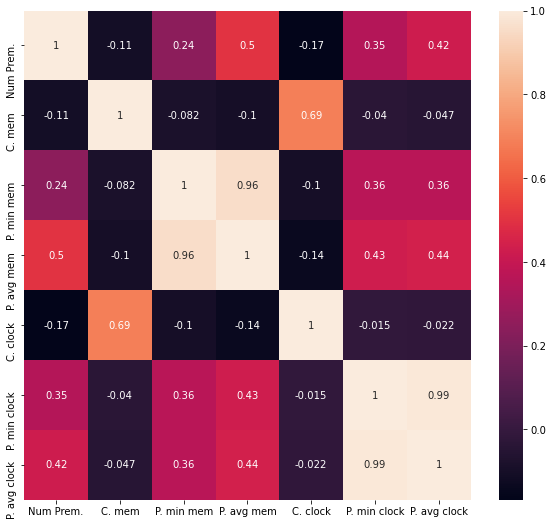

In [24]:
plt.figure(figsize=(10,9))
corr_df = ram_rules_feat.sort_values(["Lift", "Support (abs)"]).drop(["Support (abs)", "Confidence", "Lift"], axis=1).head(50)
sn.heatmap(corr_df.corr(), annot=True)
plt.show()

No correlation, this level of analysis doesn't seem fruitful.

#### Conclusions
There are no apparent relationships between the consequent and the premises of the ram modules sold.  

### Dataframe-level associations
Here we apply to the whole dataframe taking each row as its own transaction.

In [25]:
report_cols = ["Conseq.", "Prem.", "Support (abs)", "Support (frac)", "Confidence", "Lift"]

In [26]:
def filter_rules(rule_df, filter_func_list):
    
    for idx, row in rule_df.iterrows():
        
        prems = row.loc["Prem."]
        conseqs = row.loc["Conseq."]
        
        for filter_func in filter_func_list:
            if filter_func(prems, conseqs):
                
                rule_df = rule_df.drop(row.name)
                break #Already deleted, no need for further filtering
    
    return rule_df
                
                
def filter_country_continent_curr(prems, conseq):
    #Filters all associations between currency, country and continent
    
    curr_vals = df_geo["currency"].unique()
    country_vals = df_geo["country"].unique()
    contin_vals = df_geo["continent"].unique()
    
    for prem in prems:
        if prem in curr_vals:
            
            if conseq in country_vals or conseq in contin_vals:
                return True
            
        if prem in country_vals or prem in contin_vals:
            
            if conseq in curr_vals:
                return True
            
            if conseq in country_vals or conseq in contin_vals:
                return True
                    
    return False


def filter_brand_ram_name(prems, conseq):
    #Filter associations between brand and brand's product name
    
    brand_vals = df_ram["brand"].unique()
    name_vals = df_ram["name"].unique()
    
    for prem in prems:
        if prem in brand_vals and conseq in name_vals:
            return True
        if prem in name_vals and conseq in brand_vals:
            return True
        
    return False            

A significant percentage of the rules discovered are "obvious" associations, such as "the transactions in country x use the currency of that country".  
In order to filter them out we create some ad-hoc filter rules.

In [27]:
filters = [filter_country_continent_curr, filter_brand_ram_name]

baskets_whole_df = df_sales_proc.drop(["time_code"], axis=1) #Remove time-related features
baskets_whole = baskets_whole_df.values.tolist()

#Keep only entries with Lift >=2
rules_whole = fim_apriori(baskets_whole, supp=5, zmin=2, target='r', conf=60, report='ascl', eval="l", thresh=200, prune=1)

rules_whole_df = pd.DataFrame(rules_whole, columns=report_cols).sort_values(["Lift", "Support (abs)"], ascending=False)
rules_whole_df_filtered = filter_rules(rules_whole_df, filters)

print('Number of rules:', rules_whole_df_filtered.shape[0])

Number of rules: 25


In order to sift through the rules more easily we used the pruning functionality of the apriori implementation.

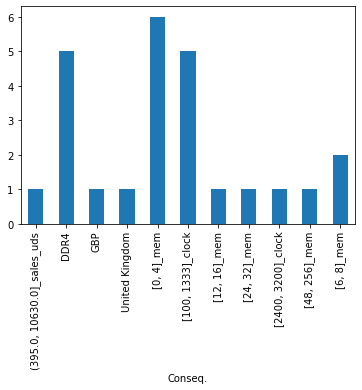

In [28]:
rules_whole_df_filtered.groupby("Conseq.").size().plot(kind="bar")
plt.show()

We will take a brief look at each consequent in order to see if there is any new information to be had.

In [29]:
rules_whole_df_filtered.loc[rules_whole_df_filtered["Conseq."] == '(395.0, 10630.0]_sales_uds'].head()

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift
12,"(395.0, 10630.0]_sales_uds","([48, 256]_mem,)",194924,0.058313,0.883769,8.864869


The ram modules that have a lot of memory cost the most.

In [30]:
rules_whole_df_filtered.loc[rules_whole_df_filtered["Conseq."] == 'DDR4'].head(10)

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift
0,DDR4,"([3300, 4600]_clock,)",167989,0.050255,1.000000,2.836010
35,DDR4,"([2400, 3200]_clock,)",739904,0.221349,0.837388,2.374840
10,DDR4,"([48, 256]_mem, (395.0, 10630.0]_sales_uds)",145080,0.043402,0.744290,2.110814
13,DDR4,"([48, 256]_mem,)",159804,0.047807,0.724538,2.054796
22,DDR4,"((395.0, 10630.0]_sales_uds,)",238866,0.071459,0.716788,2.032818


Here the rules roughly point out which are the clock rates, price and memory size associated with DDR4.

In [31]:
rules_whole_df_filtered.loc[rules_whole_df_filtered["Conseq."].isin(['United Kingdom', 'GBP'])].head(10)

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift
17,United Kingdom,"(pricespy_unknown,)",289464,0.086596,0.908576,5.940088
18,GBP,"(pricespy_unknown,)",289464,0.086596,0.908576,5.940088


As we pointed out in task 1, pricespy_unknown is a UK-based price search engine so no surprises here.

In [32]:
rules_whole_df_filtered.loc[rules_whole_df_filtered["Conseq."]\
                            .isin(['[0, 4]_mem', '[6, 8]_mem', '[12, 16]_mem', '[24, 32]_mem', '[48, 256]_mem'])].head(20)

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift
11,"[48, 256]_mem","((395.0, 10630.0]_sales_uds, DDR4)",145080,0.043402,0.607370,9.205001
23,"[24, 32]_mem","((246.0, 395.0]_sales_uds,)",212409,0.063544,0.635930,4.545196
24,"[0, 4]_mem","((0.999, 27.0]_sales_uds, [100, 1333]_clock)",265411,0.079400,0.997463,3.420766
27,"[0, 4]_mem","((0.999, 27.0]_sales_uds,)",340528,0.101872,0.996264,3.416653
29,"[0, 4]_mem","(DDR2, [100, 1333]_clock)",313826,0.093884,0.889179,3.049409
32,"[0, 4]_mem","(DDR2,)",313826,0.093884,0.889179,3.049409
20,"[0, 4]_mem","((27.0, 41.0]_sales_uds,)",287597,0.086037,0.864496,2.964758
21,"[12, 16]_mem","((134.0, 177.0]_sales_uds,)",240845,0.072051,0.723595,2.876512
28,"[6, 8]_mem","((57.0, 78.0]_sales_uds,)",225192,0.067368,0.648568,2.584337
19,"[6, 8]_mem","((78.0, 99.0]_sales_uds,)",204856,0.061285,0.628549,2.504566


Here we can see the association rules between the memory size and the price/clock/memory type.  
These rules allow us (with good confidence) to estimate the amount of ram in module given its price.  
It also points out that DDR2 sales consist mostly of small memory modules.

In [33]:
rules_whole_df_filtered.loc[rules_whole_df_filtered["Conseq."].isin(['[100, 1333]_clock', '[2400, 3200]_clock'])].head(10)

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift
31,"[100, 1333]_clock","(DDR2,)",352939,0.105585,1.000000,3.510793
30,"[100, 1333]_clock","(DDR2, [0, 4]_mem)",313826,0.093884,1.000000,3.510793
25,"[100, 1333]_clock","((0.999, 27.0]_sales_uds, [0, 4]_mem)",265411,0.079400,0.779410,2.736348
26,"[100, 1333]_clock","((0.999, 27.0]_sales_uds,)",266086,0.079602,0.778473,2.733058
36,"[2400, 3200]_clock","(DDR4,)",739904,0.221349,0.627749,2.374840
38,"[100, 1333]_clock","([0, 4]_mem,)",640626,0.191649,0.657255,2.307485


These are the associations between the clock and the other features.  
We can see that, as we pointed out in the pre-processing step, the lowest clock range is very strongly associated with low-end ram (low memory/cost).

### Comparison between top countries
In this section we will take a look at a few top countries ordered by the volume of sales and compare the frequent sequences found, in order to see if there are any apparent differences.

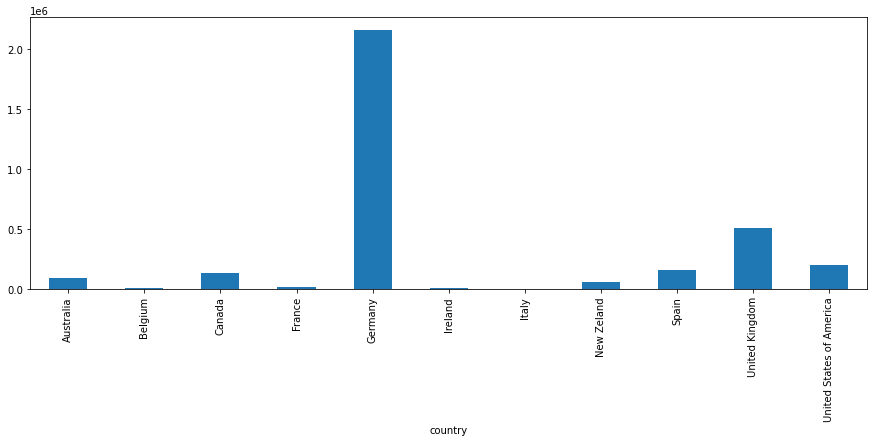

In [34]:
plt.figure(figsize=(15,5))
df_sales_proc.groupby("country").size().plot(kind="bar")
plt.show()

We will consider Germany, the UK and the US.

In [108]:
ram_sales_ger = df_sales_proc.loc[(df_sales_proc["country"] == "Germany")].shape[0]
ram_sales_uk = df_sales_proc.loc[(df_sales_proc["country"] == "United Kingdom")].shape[0]
ram_sales_us = df_sales_proc.loc[(df_sales_proc["country"] == "United States of America")].shape[0]

In [134]:
help(fim_apriori)

Help on built-in function apriori in module fim:

apriori(...)
    apriori (tracts, target='s', supp=10, zmin=1, zmax=None, report='a',
             eval='x', agg='x', thresh=10, prune=None, algo='b', mode='',
             border=None)
    Find frequent item sets with the Apriori algorithm.
    tracts  transaction database to mine (mandatory)
            The database must be an iterable of transactions;
            each transaction must be an iterable of items;
            each item must be a hashable object.
            If the database is a dictionary, the transactions are
            the keys, the values their (integer) multiplicities.
    target  type of frequent item sets to find     (default: s)
            s/a   sets/all   all     frequent item sets
            c     closed     closed  frequent item sets
            m     maximal    maximal frequent item sets
            g     gens       generators
            r     rules      association rules
    supp    minimum support of an i

#### Rules Germany

In [142]:
baskets_ger_df = df_sales_proc.loc[df_sales_proc["country"] == "Germany"].drop(["time_code"], axis=1) #Remove time-related features
baskets_ger_df = baskets_ger_df.values.tolist()

#Keep only entries with Lift >=2
rules_ger = fim_apriori(baskets_ger_df, supp=5, zmin=2, target='r', conf=60, report='ascl', eval="l", thresh=200, prune=1)

rules_ger_df = pd.DataFrame(rules_ger, columns=report_cols).sort_values(["Lift", "Support (abs)"], ascending=False)
rules_ger_df_filtered = filter_rules(rules_ger_df, filters)
rules_ger_df_filtered.loc[:, "Country"] = "Germany"

print('Number of rules:', rules_ger_df_filtered.shape[0])

Number of rules: 25


#### Rules UK

In [36]:
baskets_uk_df = df_sales_proc.loc[df_sales_proc["country"] == "United Kingdom"].drop(["time_code"], axis=1) #Remove time-related features
baskets_uk_df = baskets_uk_df.values.tolist()

#Keep only entries with Lift >=2
rules_uk = fim_apriori(baskets_uk_df, supp=5, zmin=2, target='r', conf=60, report='ascl', eval="l", thresh=200, prune=1)

rules_uk_df = pd.DataFrame(rules_uk, columns=report_cols).sort_values(["Lift", "Support (abs)"], ascending=False)
rules_uk_df_filtered = filter_rules(rules_uk_df, filters)
rules_uk_df_filtered.loc[:, "Country"] = "United Kingdom"

print('Number of rules:', rules_uk_df_filtered.shape[0])

Number of rules: 14


#### Rules US

In [37]:
baskets_us_df = df_sales_proc.loc[df_sales_proc["country"] == "United States of America"]\
        .drop(["time_code"], axis=1) #Remove time-related features
baskets_us_df = baskets_us_df.values.tolist()

#Keep only entries with Lift >=2
rules_us = fim_apriori(baskets_us_df, supp=5, zmin=2, target='r', conf=60, report='ascl', eval="l", thresh=200, prune=1)

rules_us_df = pd.DataFrame(rules_us, columns=report_cols).sort_values(["Lift", "Support (abs)"], ascending=False)
rules_us_df_filtered = filter_rules(rules_us_df, filters)
rules_us_df_filtered.loc[:, "Country"] = "United States of America"

print('Number of rules:', rules_us_df_filtered.shape[0])

Number of rules: 13


#### Comparison

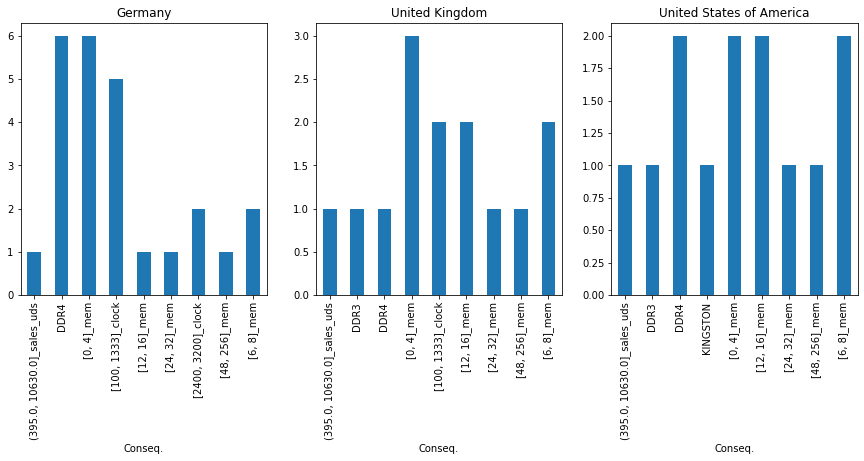

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
rules_ger_df_filtered.groupby("Conseq.").size().plot(kind="bar", ax=axes[0], title="Germany")
rules_uk_df_filtered.groupby("Conseq.").size().plot(kind="bar", ax=axes[1], title="United Kingdom")
rules_us_df_filtered.groupby("Conseq.").size().plot(kind="bar", ax=axes[2], title="United States of America")
plt.show()

In [158]:
rules_joint_df = rules_ger_df_filtered.append(rules_uk_df_filtered, ignore_index=True).append(rules_us_df_filtered, ignore_index=True)
rules_joint_df.head()

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift,Country
0,"[48, 256]_mem","((395.0, 10630.0]_sales_uds, DDR4)",84270,0.039009,0.622364,9.972547,Germany
1,"(395.0, 10630.0]_sales_uds","([48, 256]_mem,)",119799,0.055456,0.888605,9.360514,Germany
2,"[24, 32]_mem","((246.0, 395.0]_sales_uds,)",130956,0.060620,0.649828,4.991779,Germany
3,"[12, 16]_mem","((134.0, 177.0]_sales_uds,)",148577,0.068777,0.715513,3.131516,Germany
4,"[0, 4]_mem","((0.999, 27.0]_sales_uds, [100, 1333]_clock)",225261,0.104275,0.998807,2.943585,Germany


For some reason some of the rules with a support < 5% are still being showed, we will prune them by hand.

In [159]:
pruned_idx = rules_joint_df.loc[rules_joint_df["Support (frac)"] < 5/100].index
rules_joint_df = rules_joint_df.drop(pruned_idx)
rules_joint_df.head()

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift,Country
1,"(395.0, 10630.0]_sales_uds","([48, 256]_mem,)",119799,0.055456,0.888605,9.360514,Germany
2,"[24, 32]_mem","((246.0, 395.0]_sales_uds,)",130956,0.060620,0.649828,4.991779,Germany
3,"[12, 16]_mem","((134.0, 177.0]_sales_uds,)",148577,0.068777,0.715513,3.131516,Germany
4,"[0, 4]_mem","((0.999, 27.0]_sales_uds, [100, 1333]_clock)",225261,0.104275,0.998807,2.943585,Germany
5,"[0, 4]_mem","((0.999, 27.0]_sales_uds,)",276919,0.128188,0.998392,2.942362,Germany


##### Sales price

In [160]:
rules_joint_df.loc[rules_joint_df["Conseq."] == '(395.0, 10630.0]_sales_uds']

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift,Country
1,"(395.0, 10630.0]_sales_uds","([48, 256]_mem,)",119799,0.055456,0.888605,9.360514,Germany
25,"(395.0, 10630.0]_sales_uds","([48, 256]_mem,)",38567,0.075431,0.906030,7.319942,United Kingdom


The US is the only country considered that doesn't have an association rule between the ram with the highest memory size and the highest price range.

##### DDR3

In [161]:
rules_joint_df.loc[rules_joint_df["Conseq."] == 'DDR3']

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift,Country
37,DDR3,"([1600, 1800]_clock,)",101786,0.199078,0.999754,2.149367,United Kingdom
47,DDR3,"([1600, 1800]_clock,)",41444,0.207826,1.000000,2.154648,United States of America


They share also the rule for DDR3, except for Germany.

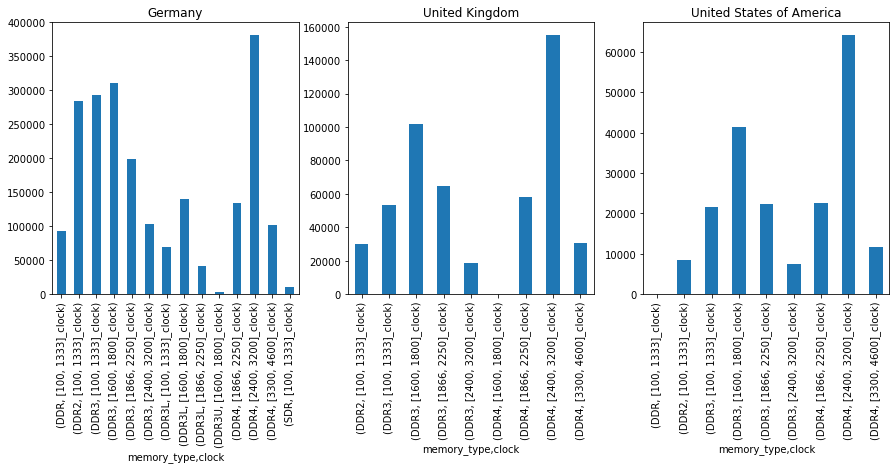

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
df_sales_proc.loc[(df_sales_proc["country"] == "Germany")]\
        .groupby(["memory_type", "clock"]).size().plot(kind="bar", ax=axes[0], title="Germany")
df_sales_proc.loc[(df_sales_proc["country"] == "United Kingdom")]\
        .groupby(["memory_type", "clock"]).size().plot(kind="bar", ax=axes[1], title="United Kingdom")
df_sales_proc.loc[(df_sales_proc["country"] == "United States of America")]\
        .groupby(["memory_type", "clock"]).size().plot(kind="bar", ax=axes[2], title="United States of America")
plt.show()

We can see, from the plots of the number of entries grouped by memory type and clock, that in the UK/US the DDR3 transaction distribution is much more concentrated on the 1600-1800 clock range causing the support rule to have a higher confidence/lift and therefore they do not get pruned.

##### DDR4

In [162]:
rules_joint_df.loc[rules_joint_df["Conseq."] == 'DDR4']

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift,Country
9,DDR4,"([2400, 3200]_clock,)",381118,0.176422,0.788188,2.760223,Germany
20,DDR4,"((395.0, 10630.0]_sales_uds,)",135403,0.062679,0.660258,2.312214,Germany
22,DDR4,"(Mindfactory,)",141451,0.065479,0.607344,2.126910,Germany
38,DDR4,"([3300, 4600]_clock,)",30750,0.060142,1.000000,2.099676,United Kingdom
50,DDR4,"([3300, 4600]_clock,)",11742,0.058882,1.000000,2.024312,United States of America
51,DDR4,"(G.Skill Ripjaws V,)",10539,0.052849,1.000000,2.024312,United States of America


Here we have multiple kind of premises for the same consequent.  
Let's take a look at them one by one.

###### DDR4

Clock


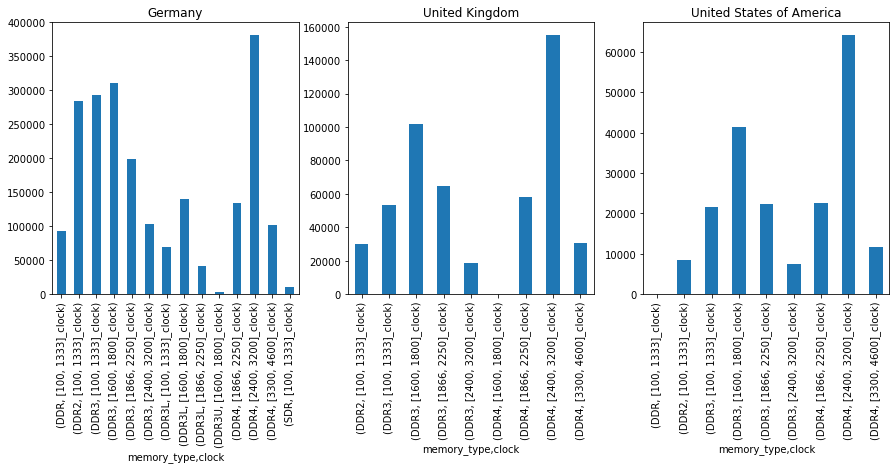

Total ram sales Germany: 2160260, 5% support: 108013
Total ram sales UK 511288, 5% support: 25564
Total ram sales US 199417, 5% support: 9970


In [109]:
print("Clock")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
df_sales_proc.loc[(df_sales_proc["country"] == "Germany")]\
        .groupby(["memory_type", "clock"]).size().plot(kind="bar", ax=axes[0], title="Germany")
df_sales_proc.loc[(df_sales_proc["country"] == "United Kingdom")]\
        .groupby(["memory_type", "clock"]).size().plot(kind="bar", ax=axes[1], title="United Kingdom")
df_sales_proc.loc[(df_sales_proc["country"] == "United States of America")]\
        .groupby(["memory_type", "clock"]).size().plot(kind="bar", ax=axes[2], title="United States of America")
plt.show()

print(f'Total ram sales Germany: {ram_sales_ger}, 5% support: {ram_sales_ger*5//100}')
print(f'Total ram sales UK {ram_sales_uk}, 5% support: {ram_sales_uk*5//100}')
print(f'Total ram sales US {ram_sales_us}, 5% support: {ram_sales_us*5//100}')

The [2400, 3200]_clock premise is missing from UK/US due to low lift since, even though the confidence is high, the support for both that clock range and DDR4 is also high resulting in a lift below the cutoff point.  

Meanwhile, in Germany, there is no association with premise [3300, 4600]_clock due to the low support for this feature.

Ram name


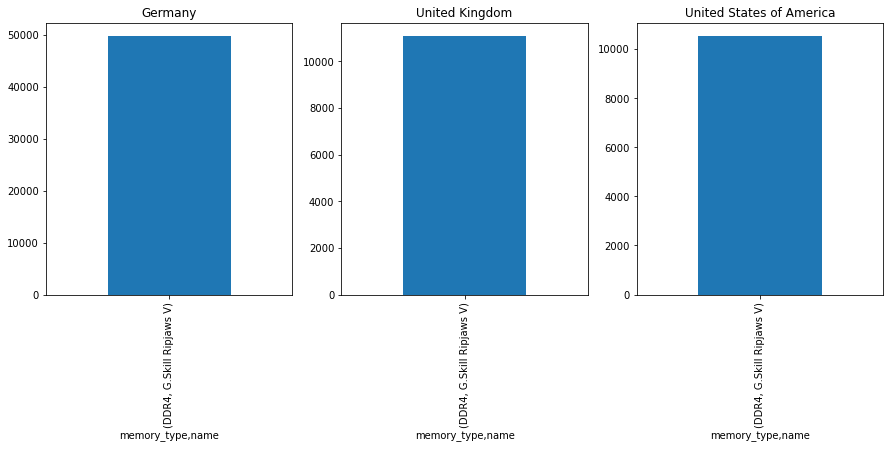

Total ram sales Germany: 2160260, 5% support: 108013
Total ram sales UK 511288, 5% support: 25564
Total ram sales US 199417, 5% support: 9970


In [166]:
print("Ram name")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.subplots_adjust(hspace=0.9, wspace=0.2)

df_sales_proc.loc[(df_sales_proc["country"] == "Germany") & (df_sales_proc["name"] == "G.Skill Ripjaws V")]\
        .groupby(["memory_type", "name"]).size().nlargest(10).plot(kind="bar", ax=axes[0], title="Germany")
df_sales_proc.loc[(df_sales_proc["country"] == "United Kingdom") & (df_sales_proc["name"] == "G.Skill Ripjaws V")]\
        .groupby(["memory_type", "name"]).size().nlargest(10).plot(kind="bar", ax=axes[1], title="United Kingdom")
df_sales_proc.loc[(df_sales_proc["country"] == "United States of America") & (df_sales_proc["name"] == "G.Skill Ripjaws V")]\
        .groupby(["memory_type", "name"]).size().nlargest(10).plot(kind="bar", ax=axes[2], title="United States of America")
plt.show()

print(f'Total ram sales Germany: {ram_sales_ger}, 5% support: {ram_sales_ger*5//100}')
print(f'Total ram sales UK {ram_sales_uk}, 5% support: {ram_sales_uk*5//100}')
print(f'Total ram sales US {ram_sales_us}, 5% support: {ram_sales_us*5//100}')

The ram name premises are also easily explainable by looking at their distribution: in all the countries considered the confidence for the ram model Corsair Vengeance is 1, however the support for that premise is below 5% everywhere except the US.  

Vendor


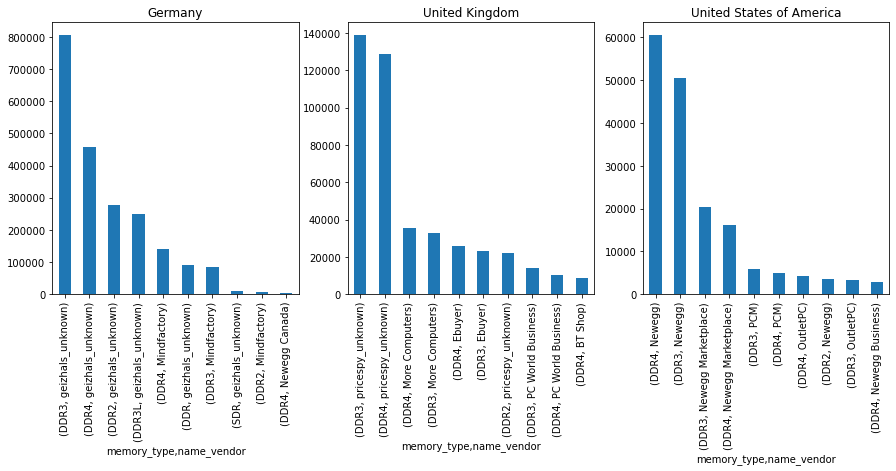

Total ram sales Germany: 2160260, 5% support: 108013
Total ram sales UK 511288, 5% support: 25564
Total ram sales US 199417, 5% support: 9970


In [121]:
print("Vendor")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
df_sales_proc.loc[(df_sales_proc["country"] == "Germany")]\
        .groupby(["memory_type", "name_vendor"]).size().nlargest(10).plot(kind="bar", ax=axes[0], title="Germany")
df_sales_proc.loc[(df_sales_proc["country"] == "United Kingdom")]\
        .groupby(["memory_type", "name_vendor"]).size().nlargest(10).plot(kind="bar", ax=axes[1], title="United Kingdom")
df_sales_proc.loc[(df_sales_proc["country"] == "United States of America")]\
        .groupby(["memory_type", "name_vendor"]).size().nlargest(10).plot(kind="bar", ax=axes[2], title="United States of America")
plt.show()

print(f'Total ram sales Germany: {ram_sales_ger}, 5% support: {ram_sales_ger*5//100}')
print(f'Total ram sales UK {ram_sales_uk}, 5% support: {ram_sales_uk*5//100}')
print(f'Total ram sales US {ram_sales_us}, 5% support: {ram_sales_us*5//100}')

We can see that there is very little overlapping between the vendors in each country, Germany sales are domanited by german vendors, UK by british ones, etc.  
Therefore it seems obvious that Mindfactory is a premise only for Germany.  

The interesting part is that there is no rule with a vendor as premise in the UK or US, this seems due to the fact that the sales of DDR3 and DDR4 are fairly balanced in each vendor, drastically lowering the confidence of any potential rule.

Sales (USD)


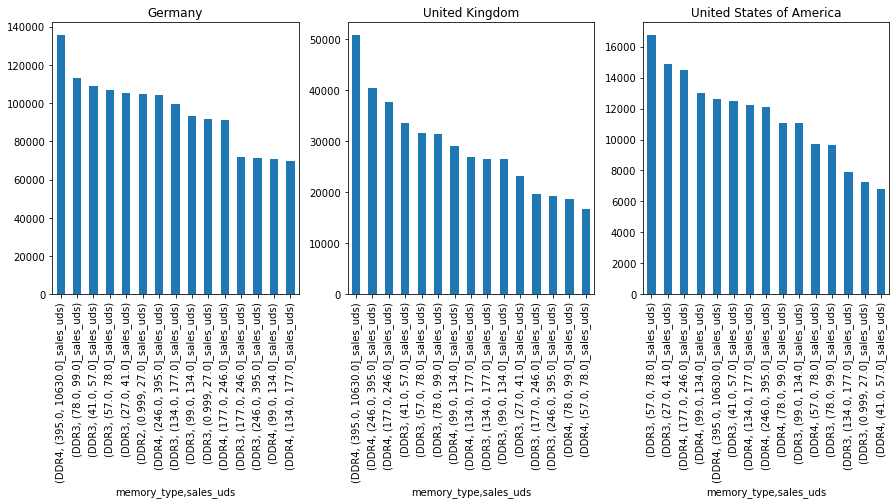

Total ram sales Germany: 2160260, 5% support: 108013
Total ram sales UK 511288, 5% support: 25564
Total ram sales US 199417, 5% support: 9970


In [169]:
print("Sales (USD)")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
df_sales_proc.loc[(df_sales_proc["country"] == "Germany")]\
        .groupby(["memory_type", "sales_uds"]).size().nlargest(15).plot(kind="bar", ax=axes[0], title="Germany")
df_sales_proc.loc[(df_sales_proc["country"] == "United Kingdom")]\
        .groupby(["memory_type", "sales_uds"]).size().nlargest(15).plot(kind="bar", ax=axes[1], title="United Kingdom")
df_sales_proc.loc[(df_sales_proc["country"] == "United States of America")]\
        .groupby(["memory_type", "sales_uds"]).size().nlargest(15).plot(kind="bar", ax=axes[2], title="United States of America")
plt.show()

print(f'Total ram sales Germany: {ram_sales_ger}, 5% support: {ram_sales_ger*5//100}')
print(f'Total ram sales UK {ram_sales_uk}, 5% support: {ram_sales_uk*5//100}')
print(f'Total ram sales US {ram_sales_us}, 5% support: {ram_sales_us*5//100}')

We can see that the confidence/support for this rule/premise is high enough to exceed the threshold in each country, therefore Germany is the only country with this kind of rule due to a higher lift score.

##### Memory size

In [170]:
rules_joint_df.loc[rules_joint_df["Conseq."]\
                            .isin(['[0, 4]_mem', '[6, 8]_mem', '[12, 16]_mem', '[24, 32]_mem', '[48, 256]_mem'])]

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift,Country
2,"[24, 32]_mem","((246.0, 395.0]_sales_uds,)",130956,0.060620,0.649828,4.991779,Germany
3,"[12, 16]_mem","((134.0, 177.0]_sales_uds,)",148577,0.068777,0.715513,3.131516,Germany
4,"[0, 4]_mem","((0.999, 27.0]_sales_uds, [100, 1333]_clock)",225261,0.104275,0.998807,2.943585,Germany
5,"[0, 4]_mem","((0.999, 27.0]_sales_uds,)",276919,0.128188,0.998392,2.942362,Germany
11,"[6, 8]_mem","((57.0, 78.0]_sales_uds,)",138941,0.064317,0.638067,2.662960,Germany
12,"[0, 4]_mem","(DDR2, [100, 1333]_clock)",254014,0.117585,0.891646,2.627771,Germany
13,"[0, 4]_mem","(DDR2,)",254014,0.117585,0.891646,2.627771,Germany
14,"[0, 4]_mem","((27.0, 41.0]_sales_uds,)",209229,0.096854,0.890746,2.625117,Germany
15,"[6, 8]_mem","((78.0, 99.0]_sales_uds,)",129064,0.059745,0.627575,2.619173,Germany
24,"[0, 4]_mem","([100, 1333]_clock,)",523363,0.242269,0.698754,2.059297,Germany


Here we have just three kinds of premises: price, clock and memory type.  
We also have some rules with two premises (price, clock or memory type) which states the obvious: cheap ram with a low clock/old memory type most likely has a low capacity.

Sales (USD)


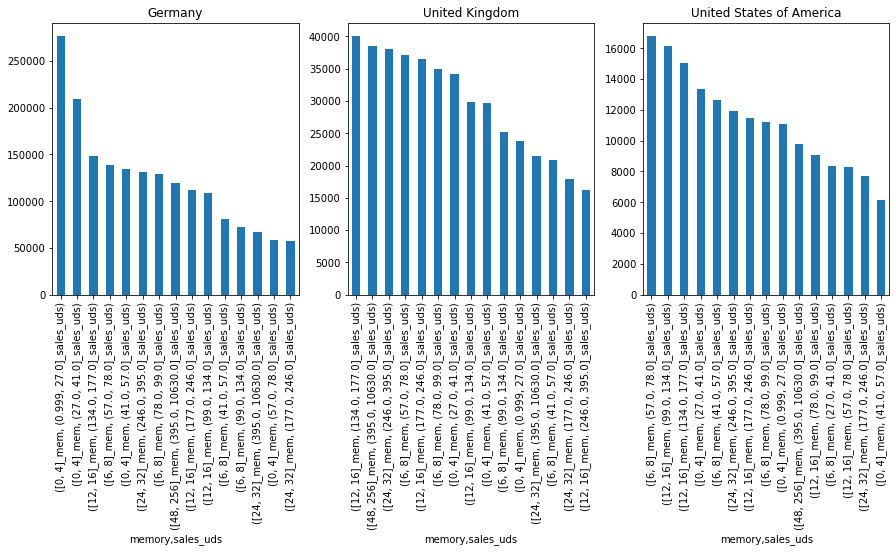

Total ram sales Germany: 2160260, 5% support: 108013
Total ram sales UK 511288, 5% support: 25564
Total ram sales US 199417, 5% support: 9970


In [171]:
print("Sales (USD)")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
df_sales_proc.loc[(df_sales_proc["country"] == "Germany")]\
        .groupby(["memory", "sales_uds"]).size().nlargest(15).plot(kind="bar", ax=axes[0], title="Germany")
df_sales_proc.loc[(df_sales_proc["country"] == "United Kingdom")]\
        .groupby(["memory", "sales_uds"]).size().nlargest(15).plot(kind="bar", ax=axes[1], title="United Kingdom")
df_sales_proc.loc[(df_sales_proc["country"] == "United States of America")]\
        .groupby(["memory", "sales_uds"]).size().nlargest(15).plot(kind="bar", ax=axes[2], title="United States of America")
plt.show()

print(f'Total ram sales Germany: {ram_sales_ger}, 5% support: {ram_sales_ger*5//100}')
print(f'Total ram sales UK {ram_sales_uk}, 5% support: {ram_sales_uk*5//100}')
print(f'Total ram sales US {ram_sales_us}, 5% support: {ram_sales_us*5//100}')

There are plenty of valid rules concerning prices in each country, however the UK is the only country that has a rule with [48, 256]_mem as a consequent.  
Each country seems to have a confidence/support high enough (we already saw above that there is a strong association between high capacity and high prices), the only differentiating thing between the UK and the others is therefore the lift score.

Clock


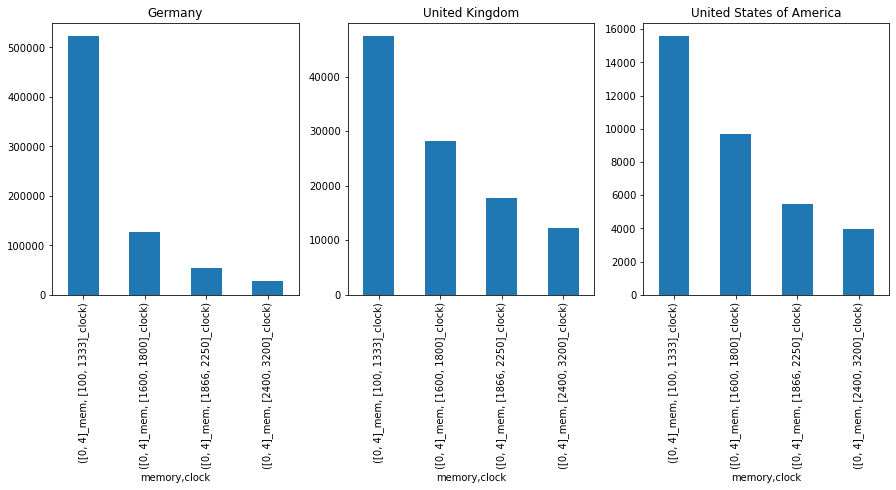

Total ram sales Germany: 2160260, 5% support: 108013
Total ram sales UK 511288, 5% support: 25564
Total ram sales US 199417, 5% support: 9970


In [173]:
print("Clock")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
df_sales_proc.loc[(df_sales_proc["country"] == "Germany") & (df_sales_proc["memory"] == "[0, 4]_mem")]\
        .groupby(["memory", "clock"]).size().nlargest(15).plot(kind="bar", ax=axes[0], title="Germany")
df_sales_proc.loc[(df_sales_proc["country"] == "United Kingdom") & (df_sales_proc["memory"] == "[0, 4]_mem")]\
        .groupby(["memory", "clock"]).size().nlargest(15).plot(kind="bar", ax=axes[1], title="United Kingdom")
df_sales_proc.loc[(df_sales_proc["country"] == "United States of America") & (df_sales_proc["memory"] == "[0, 4]_mem")]\
        .groupby(["memory", "clock"]).size().nlargest(15).plot(kind="bar", ax=axes[2], title="United States of America")
plt.show()

print(f'Total ram sales Germany: {ram_sales_ger}, 5% support: {ram_sales_ger*5//100}')
print(f'Total ram sales UK {ram_sales_uk}, 5% support: {ram_sales_uk*5//100}')
print(f'Total ram sales US {ram_sales_us}, 5% support: {ram_sales_us*5//100}')

In Germany there is an association rule with [100, 1333]_clock as a premise and [0, 4]_mem as a consequent.  
We can see that this is due to a low confidence score in the UK/US, in which the distribution of these features in the ram sales is less skewed.

Memory type


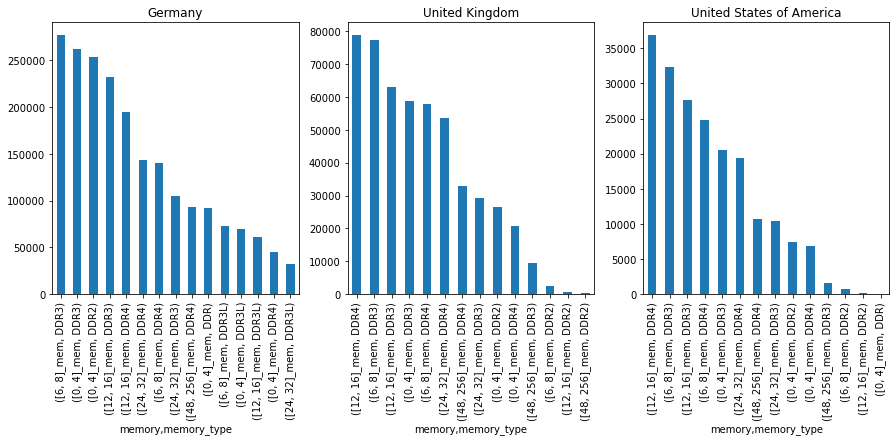

Total ram sales Germany: 2160260, 5% support: 108013
Total ram sales UK 511288, 5% support: 25564
Total ram sales US 199417, 5% support: 9970


In [174]:
print("Memory type")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
df_sales_proc.loc[(df_sales_proc["country"] == "Germany")]\
        .groupby(["memory", "memory_type"]).size().nlargest(15).plot(kind="bar", ax=axes[0], title="Germany")
df_sales_proc.loc[(df_sales_proc["country"] == "United Kingdom")]\
        .groupby(["memory", "memory_type"]).size().nlargest(15).plot(kind="bar", ax=axes[1], title="United Kingdom")
df_sales_proc.loc[(df_sales_proc["country"] == "United States of America")]\
        .groupby(["memory", "memory_type"]).size().nlargest(15).plot(kind="bar", ax=axes[2], title="United States of America")
plt.show()

print(f'Total ram sales Germany: {ram_sales_ger}, 5% support: {ram_sales_ger*5//100}')
print(f'Total ram sales UK {ram_sales_uk}, 5% support: {ram_sales_uk*5//100}')
print(f'Total ram sales US {ram_sales_us}, 5% support: {ram_sales_us*5//100}')

Germany and the UK present an association between DDR2 and [0, 4]_mem.  
This rule is absent in the US due to a low support.  
It seems that no other rule of this kind exists due to the more varied distribution of capacities for DDR3/DDR4 type of ram, resulting in a low confidence score.

##### Clock

In [48]:
rules_joint_df.loc[rules_joint_df["Conseq."].isin(['[100, 1333]_clock', '[2400, 3200]_clock'])]

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift,Country
6,"[100, 1333]_clock","(DDR2,)",284882,0.131874,1.000000,2.884212,Germany
7,"[100, 1333]_clock","(DDR2, [0, 4]_mem)",254014,0.117585,1.000000,2.884212,Germany
8,"[2400, 3200]_clock","((395.0, 10630.0]_sales_uds, DDR4)",85995,0.039808,0.635104,2.837404,Germany
10,"[2400, 3200]_clock","(DDR4,)",381118,0.176422,0.617828,2.760223,Germany
18,"[100, 1333]_clock","((0.999, 27.0]_sales_uds, [0, 4]_mem)",225261,0.104275,0.813454,2.346175,Germany
19,"[100, 1333]_clock","((0.999, 27.0]_sales_uds,)",225530,0.104399,0.813116,2.345199,Germany
23,"[100, 1333]_clock","([0, 4]_mem,)",523363,0.242269,0.713990,2.059297,Germany
27,"[100, 1333]_clock","(DDR2,)",29960,0.058597,1.000000,6.161061,United Kingdom
28,"[100, 1333]_clock","(DDR2, [0, 4]_mem)",26386,0.051607,1.000000,6.161061,United Kingdom


Memory type


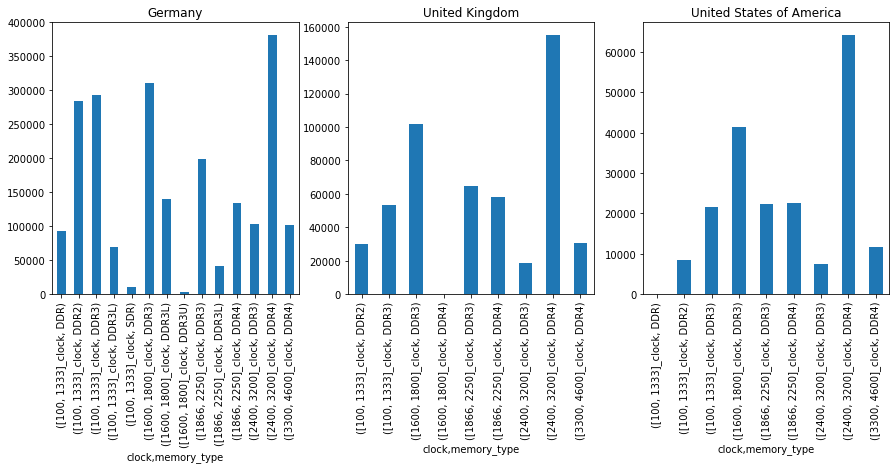

Total ram sales Germany: 2160260, 5% support: 108013
Total ram sales UK 511288, 5% support: 25564
Total ram sales US 199417, 5% support: 9970


In [178]:
print("Memory type")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
df_sales_proc.loc[(df_sales_proc["country"] == "Germany")]\
        .groupby(["clock", "memory_type"]).size().plot(kind="bar", ax=axes[0], title="Germany")
df_sales_proc.loc[(df_sales_proc["country"] == "United Kingdom")]\
        .groupby(["clock", "memory_type"]).size().plot(kind="bar", ax=axes[1], title="United Kingdom")
df_sales_proc.loc[(df_sales_proc["country"] == "United States of America")]\
        .groupby(["clock", "memory_type"]).size().plot(kind="bar", ax=axes[2], title="United States of America")
plt.show()

print(f'Total ram sales Germany: {ram_sales_ger}, 5% support: {ram_sales_ger*5//100}')
print(f'Total ram sales UK {ram_sales_uk}, 5% support: {ram_sales_uk*5//100}')
print(f'Total ram sales US {ram_sales_us}, 5% support: {ram_sales_us*5//100}')

Both Germany and the UK have a rule associating DDR2 with [100, 1333]_clock	(in accordance with the rules above), the US lacks such a rule due to a low support for DDR2.  

Germany also presents a rule with DDR4 and [2400, 3200]_clock, while the other two countries do not due to a low lift score (the sales are more concentrated on ram modules with these clock/memory type, making the rule less interesting).

Memory size


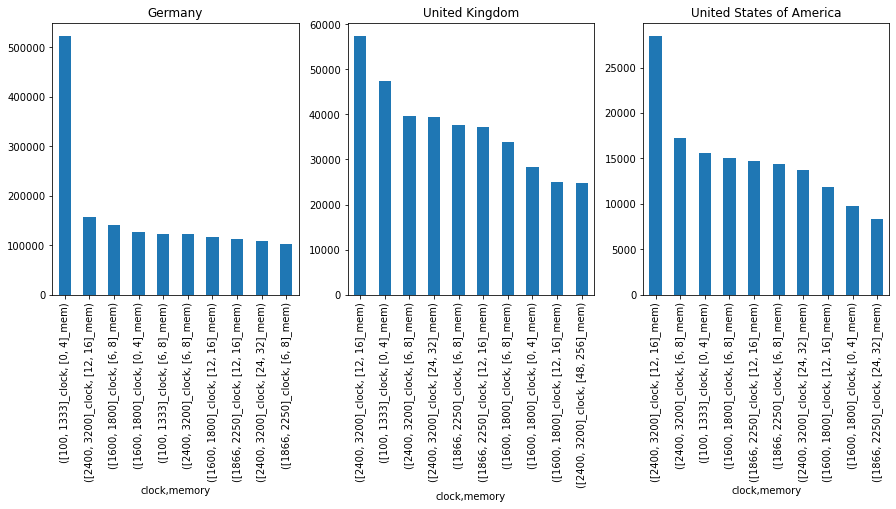

Total ram sales Germany: 2160260, 5% support: 108013
Total ram sales UK 511288, 5% support: 25564
Total ram sales US 199417, 5% support: 9970


In [182]:
print("Memory size")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
df_sales_proc.loc[(df_sales_proc["country"] == "Germany")]\
        .groupby(["clock", "memory"]).size().nlargest(10).plot(kind="bar", ax=axes[0], title="Germany")
df_sales_proc.loc[(df_sales_proc["country"] == "United Kingdom")]\
        .groupby(["clock", "memory"]).size().nlargest(10).plot(kind="bar", ax=axes[1], title="United Kingdom")
df_sales_proc.loc[(df_sales_proc["country"] == "United States of America")]\
        .groupby(["clock", "memory"]).size().nlargest(10).plot(kind="bar", ax=axes[2], title="United States of America")
plt.show()

print(f'Total ram sales Germany: {ram_sales_ger}, 5% support: {ram_sales_ger*5//100}')
print(f'Total ram sales UK {ram_sales_uk}, 5% support: {ram_sales_uk*5//100}')
print(f'Total ram sales US {ram_sales_us}, 5% support: {ram_sales_us*5//100}')

Germany is the only country with a rule with memory size as a premise ([0, 4]_mem).  
This rule does not apply to the UK/US due to low a confidence score, however by including DDR2 in the premises the UK also gets a valid rule.

Sales (USD)


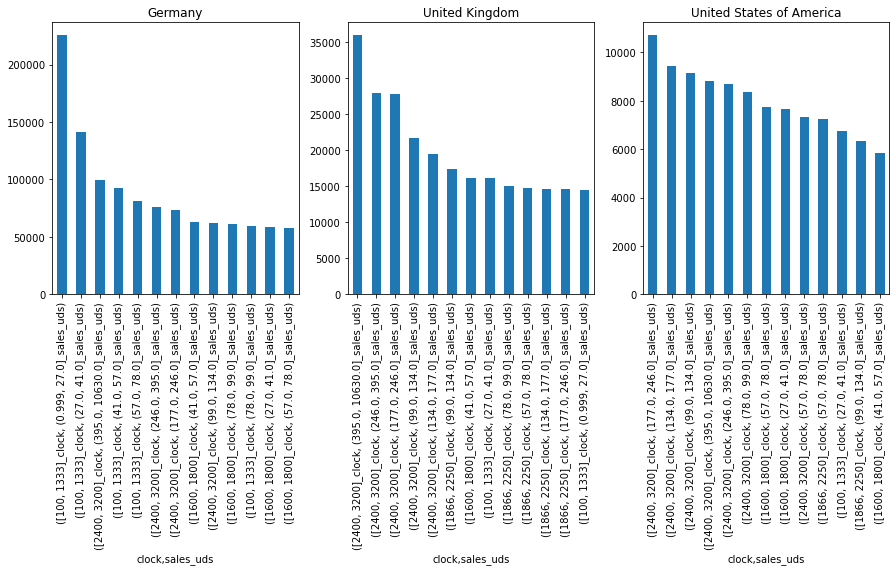

Total ram sales Germany: 2160260, 5% support: 108013
Total ram sales UK 511288, 5% support: 25564
Total ram sales US 199417, 5% support: 9970


In [184]:
print("Sales (USD)")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
df_sales_proc.loc[(df_sales_proc["country"] == "Germany")]\
        .groupby(["clock", "sales_uds"]).size().nlargest(13).plot(kind="bar", ax=axes[0], title="Germany")
df_sales_proc.loc[(df_sales_proc["country"] == "United Kingdom")]\
        .groupby(["clock", "sales_uds"]).size().nlargest(13).plot(kind="bar", ax=axes[1], title="United Kingdom")
df_sales_proc.loc[(df_sales_proc["country"] == "United States of America")]\
        .groupby(["clock", "sales_uds"]).size().nlargest(13).plot(kind="bar", ax=axes[2], title="United States of America")
plt.show()

print(f'Total ram sales Germany: {ram_sales_ger}, 5% support: {ram_sales_ger*5//100}')
print(f'Total ram sales UK {ram_sales_uk}, 5% support: {ram_sales_uk*5//100}')
print(f'Total ram sales US {ram_sales_us}, 5% support: {ram_sales_us*5//100}')

Germany presents an association rule between [100, 1333]_clock and (0.999, 27.0]_sales_uds, respectively the lowest clock range and price range.  
This rule is not present in the UK/US due to the low confidence score.

## Frequent ram sequences
Here we will try to find interesting information regarding the ram sales mining frequent sequences from a database built using time/location features and containing the ram_codes as singleton elements.  

In order to make the task computationally/time efficient we will sample the sales dataset in order to ensure a quick execution of the apriori algorithm.

### Time-based ram baskets  
In this section we simply grouped the sales by time, generating sequences with elements of size 1, where each element represents a ram module sale in that timeframe.

#### Week

In [49]:
baskets_sampled_week = df_sales_proc.sample(frac=0.002, random_state=0)
print(f"Entries sampled: {baskets_sampled_week.shape[0]}")

Entries sampled: 6685


In [50]:
baskets_week = baskets_sampled_week.groupby(pd.Grouper(key="time_code", freq="1W"))["ram_code"].apply(lambda x: [[y] for y in x])
baskets_week

time_code
2013-03-24                                             [[2432]]
2013-03-31     [[1568], [1683], [2618], [2982], [2434], [2483]]
2013-04-07     [[2778], [1644], [1470], [1486], [2772], [2131]]
2013-04-14    [[780], [2383], [1678], [2809], [1050], [1491]...
2013-04-21    [[1056], [425], [1936], [1537], [2773], [1464]...
                                    ...                        
2018-03-18    [[975], [1598], [861], [649], [711], [866], [3...
2018-03-25    [[2446], [117], [595], [2793], [1965], [1585],...
2018-04-01    [[694], [843], [3581], [1569], [162], [2724], ...
2018-04-08    [[2033], [237], [3407], [2045], [1904], [2221]...
2018-04-15    [[1041], [2445], [2443], [2276], [1169], [1362...
Freq: W-SUN, Name: ram_code, Length: 265, dtype: object

In [51]:
format_baskets = []
for row in baskets_week.values:
    format_baskets.append(row)
    
support = np.ceil(baskets_week.shape[0]*5/100)
print(f"Min. Support (abs): {support}")
ap_result = gsp_apriori(format_baskets, support, verbose=False)

Min. Support (abs): 14.0


For computational reasons we limited the search for support >= 5%.

In [52]:
result_week_df = pd.DataFrame(ap_result, columns=["Seq.", "Supp. (abs)"])

result_week_df["Supp. (frac)"] = result_week_df["Supp. (abs)"]/baskets_week.shape[0]
result_week_df["Seq. len"] = result_week_df["Seq."].apply(lambda x: len(x))

In [53]:
result_week_df.sort_values(["Seq. len", "Supp. (abs)"], ascending=False)

,Seq.,Supp. (abs),Supp. (frac),Seq. len
0,[[2185]],20,0.075472,1
9,[[656]],19,0.071698,1
13,[[804]],18,0.067925,1
15,[[977]],18,0.067925,1
2,[[2188]],17,0.064151,1
3,[[2189]],17,0.064151,1
8,[[655]],17,0.064151,1
1,[[2186]],16,0.060377,1
6,[[2440]],16,0.060377,1
11,[[659]],16,0.060377,1


##### Sub-sequences of length 1

We found found mostly sub-sequences of length one, meaning that the support is measuring which ram module have been sold consistently and for a long enough time (in this case the support asks for at least 14 weeks).

In [54]:
list_idx = []

for idx, row in result_week_df.iterrows():
    list_idx.append((row["Seq."][0][0]))
    

df_sales_proc.loc[df_sales_proc["ram_code"].isin(list_idx)].groupby("ram_code").size().describe()

count      16.000000
mean     6751.062500
std      1523.647486
min      3666.000000
25%      5530.750000
50%      7329.500000
75%      7971.250000
max      8664.000000
dtype: float64

In [55]:
df_sales_proc.groupby("ram_code").size().describe()

count    3111.000000
mean     1074.477660
std      1226.876352
min         1.000000
25%       104.000000
50%       620.000000
75%      1814.000000
max      8664.000000
dtype: float64

Note that the volume of sales for the ram module with the least support is greater than the 75% quantile value of all the other modules that don't reach the support threshold.

#### Month

In [56]:
baskets_sampled_month = df_sales_proc.sample(frac=0.0008, random_state=0)
print(f"Entries sampled: {baskets_sampled_month.shape[0]}")

Entries sampled: 2674


For computational reasons, we reduce the amount datapoints sampled.

In [57]:
baskets_month = baskets_sampled_month.groupby(pd.Grouper(key="time_code", freq="1M"))["ram_code"].apply(lambda x: [[y] for y in x])
baskets_month

time_code
2013-03-31                     [[1683], [2618], [2982], [2434]]
2013-04-30    [[2778], [2131], [780], [2383], [1678], [2809]...
2013-05-31    [[1498], [2381], [2149], [2427], [774], [2436]...
2013-06-30    [[939], [1446], [552], [1043], [1248], [1456],...
2013-07-31    [[1487], [1248], [1084], [1303], [766], [636],...
                                    ...                        
2017-12-31    [[822], [2129], [2067], [2077], [2046], [1378]...
2018-01-31    [[864], [593], [1628], [522], [2131], [955], [...
2018-02-28    [[857], [3], [764], [2298], [1907], [1339], [2...
2018-03-31    [[1640], [2978], [973], [2299], [2322], [2213]...
2018-04-30    [[618], [2033], [237], [2527], [1244], [3468],...
Freq: M, Name: ram_code, Length: 62, dtype: object

In [58]:
format_baskets = []
for row in baskets_month.values:
    format_baskets.append(row)

support = np.ceil(baskets_month.shape[0]*5/100)
print(f"Min. Support (abs): {support}")
ap_result = gsp_apriori(format_baskets, support, verbose=False)

Min. Support (abs): 4.0


In [59]:
result_month_df = pd.DataFrame(ap_result, columns=["Seq.", "Supp. (abs)"])
result_month_df["Supp. (frac)"] = result_month_df["Supp. (abs)"]/baskets_month.shape[0]
result_month_df["Seq. len"] = result_month_df["Seq."].apply(lambda x: len(x))

In [60]:
result_month_df.sort_values(["Seq. len", "Supp. (abs)"], ascending=False).head()

,Seq.,Supp. (abs),Supp. (frac),Seq. len
157,"[[1392], [1397]]",4,0.064516,2
158,"[[2188], [2440]]",4,0.064516,2
159,"[[2188], [977]]",4,0.064516,2
160,"[[656], [804]]",4,0.064516,2
161,"[[860], [147]]",4,0.064516,2


This time we have sub-sequences of length 2, even though they have a low support.

#### Analysis

In [61]:
an_ram = df_ram.loc[[1392, 1397, 2188, 2440, 2188, 977, 656, 804, 860, 147]]
an_ram = an_ram.reset_index("ram_code").astype({"ram_code":str}).set_index("ram_code") #Change indexes to string
an_ram

,brand,name,memory,memory_type,clock
ram_code,,,,,
1392,G.SKILL,G.Skill Ripjaws V,16.0,DDR4,2800
1397,G.SKILL,G.Skill Ripjaws V,16.0,DDR4,3466
2188,KINGSTON,Kingston Hyperx Fury,16.0,DDR3,1600
2440,KINGSTON,Kingston Valueram,4.0,DDR4,2133
2188,KINGSTON,Kingston Hyperx Fury,16.0,DDR3,1600
977,CRUCIAL,Crucial Ballistix Sport,16.0,DDR4,2400
656,CORSAIR,Corsair Vengeance,16.0,DDR4,2400
804,CRUCIAL,Crucial,8.0,DDR3,1600
860,CRUCIAL,Crucial,16.0,DDR4,2133


Taking a look at the features of these rams we notice that they are mostly in the memory range [8, 16] while the other features differ.  
This coupled to the fact that these ram sizes are the most popular seem to hint to the associations being just about ram modules popular/convenient enough to be sold each month.

In [62]:
an_ram["Vol."] = df_sales_merged.loc[df_sales_merged["ram_code"].isin(an_ram.index)].groupby("ram_code").size()
an_ram["Tot. sales usd"] = df_sales_merged.loc[df_sales_merged["ram_code"].isin(an_ram.index)].groupby("ram_code")["sales_uds"].sum()
an_ram

,brand,name,memory,memory_type,clock,Vol.,Tot. sales usd
ram_code,,,,,,,
1392,G.SKILL,G.Skill Ripjaws V,16.0,DDR4,2800,3267,4.814733e+05
1397,G.SKILL,G.Skill Ripjaws V,16.0,DDR4,3466,2148,4.293315e+05
2188,KINGSTON,Kingston Hyperx Fury,16.0,DDR3,1600,6734,8.961790e+05
2440,KINGSTON,Kingston Valueram,4.0,DDR4,2133,5596,2.622301e+05
2188,KINGSTON,Kingston Hyperx Fury,16.0,DDR3,1600,6734,8.961790e+05
977,CRUCIAL,Crucial Ballistix Sport,16.0,DDR4,2400,5335,8.181866e+05
656,CORSAIR,Corsair Vengeance,16.0,DDR4,2400,7975,1.396966e+06
804,CRUCIAL,Crucial,8.0,DDR3,1600,7915,7.044548e+05
860,CRUCIAL,Crucial,16.0,DDR4,2133,6996,1.182165e+06


In [63]:
display(df_sales_merged.groupby("ram_code").size().describe().rename("Vol. sales"))
display(df_sales_merged.groupby("ram_code")["sales_uds"].sum().describe().rename("Tot. sales usd"))

count    3111.000000
mean     1074.477660
std      1226.876352
min         1.000000
25%       104.000000
50%       620.000000
75%      1814.000000
max      8664.000000
Name: Vol. sales, dtype: float64

count    3.111000e+03
mean     1.893328e+05
std      3.349330e+05
min      2.025000e+01
25%      9.536781e+03
50%      5.839220e+04
75%      2.077376e+05
max      4.310282e+06
Name: Tot. sales usd, dtype: float64

Again we can see that both the sales volume and the sales total of the ram modules found are close to the maximum of the entire dataset.

#### Year
The computation of this grouping is problematic given that it contains very few sequences (which makes the support have the same absolute value for different percentages ie 5% == 1 abs, 10% == 1 abs, 20% == 1 abs).  

It also seems less useful to find sequences of ram_codes through the years given that there is a constant release of new ram modules in the market with different features/id.

### Location-based ram baskets
Similarly to the time-based section above, here we use different geographical features to define the sequences.

#### Region

In [64]:
baskets_sampled_region = df_sales_proc.sample(frac=0.0008, random_state=0)
print(f"Entries sampled: {baskets_sampled_region.shape[0]}")

Entries sampled: 2674


In [65]:
baskets_region = baskets_sampled_region.groupby(["region"])["ram_code"].apply(lambda x: [[y] for y in x])
baskets_region.head()

region
analucia              [[2517], [961], [2531], [1588], [1303], [678],...
aragon                                           [[1425], [657], [642]]
atlantic provinces                                             [[1390]]
baden-wuttemberg      [[1383], [2308], [2038], [2217], [1580], [2046...
bavaria               [[1419], [1836], [1365], [2183], [1649], [1177...
Name: ram_code, dtype: object

In [66]:
format_baskets = []
for row in baskets_region.values:
    format_baskets.append(row)
    
support = np.ceil(baskets_region.shape[0]*10/100)
ap_result = gsp_apriori(format_baskets, support, verbose=False)

In [67]:
result_region_df = pd.DataFrame(ap_result, columns=["Seq.", "Supp. (abs)"])
result_region_df["Supp. (frac)"] = result_region_df["Supp. (abs)"]/baskets_region.shape[0]
result_region_df["Seq. len"] = result_region_df["Seq."].apply(lambda x: len(x))

result_region_df.sort_values(["Seq. len", "Supp. (abs)"], ascending=False).head(10)

,Seq.,Supp. (abs),Supp. (frac),Seq. len
8,[[656]],13,0.185714,1
3,[[2185]],11,0.157143,1
10,[[804]],10,0.142857,1
1,[[147]],9,0.128571,1
5,[[2440]],9,0.128571,1
0,[[1392]],8,0.114286,1
4,[[2188]],8,0.114286,1
9,[[659]],8,0.114286,1
13,[[977]],8,0.114286,1
2,[[1591]],7,0.100000,1


Here we have sub-sequences of length 2 again.

#### Analysis

In [68]:
an_ram = df_ram.loc[[2440, 977, 515, 1581, 589, 1248]]
an_ram = an_ram.reset_index("ram_code").astype({"ram_code":str}).set_index("ram_code") #Change indexes to string
an_ram["Vol."] = df_sales_merged.loc[df_sales_merged["ram_code"].isin(an_ram.index)].groupby("ram_code").size()
an_ram

,brand,name,memory,memory_type,clock,Vol.
ram_code,,,,,,
2440,KINGSTON,Kingston Valueram,4.0,DDR4,2133,5596
977,CRUCIAL,Crucial Ballistix Sport,16.0,DDR4,2400,5335
515,CORSAIR,Corsair Dominator,16.0,DDR4,3600,2222
1581,G.SKILL,G.Skill Trident Z,8.0,DDR4,3733,1411
589,CORSAIR,Corsair Value Select,8.0,DDR3L,1333,1643
1248,G.SKILL,G.Skill Nt,4.0,DDR2,800,2108


In [69]:
display(df_sales_merged.groupby("ram_code").size().describe().rename("Vol. sales"))

count    3111.000000
mean     1074.477660
std      1226.876352
min         1.000000
25%       104.000000
50%       620.000000
75%      1814.000000
max      8664.000000
Name: Vol. sales, dtype: float64

We can already see that the sales for these modules are not that high compared to the previous case of a sequence of length 2.  
The interesting thing is that these sequences, compared to the ones above, are shared across multiple regions.  

Of course these are not the only ram sequences shared across regions.  
These results are heavily influenced by the sampling process, however we do not see any other way to perform this kind of analysis without additional computational resources.

#### Country/Continent grouping
We skipped this grouping due to the time required to execute the apriori algorithm on any significant enough sample size.

### Location/time-based ram baskets
Sequences defined by location while elements are defined by unit of time.

#### Region/week

In [70]:
baskets_sampled_region_week = df_sales_proc.sample(frac=0.001, random_state=0)
print(f"Entries sampled: {baskets_sampled_region_week.shape[0]}")

Entries sampled: 3343


In [71]:
baskets_region_week = baskets_sampled_region_week.groupby(["region", pd.Grouper(key="time_code", freq="1W")])["ram_code"]\
        .apply(lambda x: list(x))
baskets_region_week = baskets_region_week.groupby("region").apply(lambda x: [y for y in x])

baskets_region_week.head()

region
analucia              [[2982], [1936], [1936], [2381], [2455, 769], ...
aragon                                           [[1425], [642], [657]]
atlantic provinces                                             [[1390]]
baden-wuttemberg      [[1414], [2046], [979], [657], [2211], [2328],...
bavaria               [[2779], [2796], [1646], [2390], [733], [1430]...
Name: ram_code, dtype: object

In [72]:
format_baskets = []
for row in baskets_region_week.values:
    format_baskets.append(row)

support = np.ceil(baskets_region_week.shape[0]*10/100)
ap_result = gsp_apriori(format_baskets, support, verbose=False)

Support threshold is 10% for computational reasons.

In [73]:
result_region_week_df = pd.DataFrame(ap_result, columns=["Seq.", "Supp. (abs)"])
result_region_week_df["Supp. (frac)"] = result_region_week_df["Supp. (abs)"]/baskets_region_week.shape[0]
result_region_week_df["Seq. len"] = result_region_week_df["Seq."].apply(lambda x: len(x))
result_region_week_df["Max elem. len"] = result_region_week_df["Seq."].apply(lambda x: np.max([len(y) for y in x]))

In [74]:
display(result_region_week_df.sort_values(["Seq. len", "Supp. (abs)"], ascending=False).head())
display(result_region_week_df.sort_values(["Max elem. len", "Supp. (abs)"], ascending=False).head())

,Seq.,Supp. (abs),Supp. (frac),Seq. len,Max elem. len
11,[[656]],13,0.183099,1,1
2,[[2185]],11,0.154930,1,1
13,[[804]],11,0.154930,1,1
15,[[977]],11,0.154930,1,1
6,[[2440]],10,0.140845,1,1


,Seq.,Supp. (abs),Supp. (frac),Seq. len,Max elem. len
11,[[656]],13,0.183099,1,1
2,[[2185]],11,0.154930,1,1
13,[[804]],11,0.154930,1,1
15,[[977]],11,0.154930,1,1
6,[[2440]],10,0.140845,1,1


Only length 1 singleton sequences.

#### Region/month

In [75]:
baskets_sampled_region_month = df_sales_proc.sample(frac=0.001, random_state=0)
print(f"Entries sampled: {baskets_sampled_region_month.shape[0]}")

Entries sampled: 3343


In [76]:
baskets_region_month = baskets_sampled_region_month.groupby(["region", pd.Grouper(key="time_code", freq="1M")])["ram_code"]\
        .apply(lambda x: list(x))
baskets_region_month = baskets_region_month.groupby("region").apply(lambda x: [y for y in x])

baskets_region_month.head()

region
analucia              [[2982], [1936, 1936], [2381], [2455, 769], [1...
aragon                                           [[1425], [642], [657]]
atlantic provinces                                             [[1390]]
baden-wuttemberg      [[1414], [2046, 979], [657], [2328, 2211], [23...
bavaria               [[2779], [2796, 1646], [2390, 733], [1430], [1...
Name: ram_code, dtype: object

In [77]:
format_baskets = []
for row in baskets_region_month.values:
    format_baskets.append(row)

support = np.ceil(baskets_region_month.shape[0]*10/100)
ap_result = gsp_apriori(format_baskets, support, verbose=False)

In [78]:
result_region_month_df = pd.DataFrame(ap_result, columns=["Seq.", "Supp. (abs)"])
result_region_month_df["Supp. (frac)"] = result_region_month_df["Supp. (abs)"]/baskets_region_month.shape[0]
result_region_month_df["Seq. len"] = result_region_month_df["Seq."].apply(lambda x: len(x))
result_region_month_df["Max elem. len"] = result_region_month_df["Seq."].apply(lambda x: np.max([len(y) for y in x]))

In [79]:
display(result_region_month_df.sort_values(["Seq. len", "Supp. (abs)"], ascending=False).head())
display(result_region_month_df.sort_values(["Max elem. len", "Supp. (abs)"], ascending=False).head())

,Seq.,Supp. (abs),Supp. (frac),Seq. len,Max elem. len
11,[[656]],13,0.183099,1,1
2,[[2185]],11,0.154930,1,1
13,[[804]],11,0.154930,1,1
15,[[977]],11,0.154930,1,1
6,[[2440]],10,0.140845,1,1


,Seq.,Supp. (abs),Supp. (frac),Seq. len,Max elem. len
11,[[656]],13,0.183099,1,1
2,[[2185]],11,0.154930,1,1
13,[[804]],11,0.154930,1,1
15,[[977]],11,0.154930,1,1
6,[[2440]],10,0.140845,1,1


Only length 1 singleton sequences.

#### (Country, continent)/(week, month)
The computational time is too high for any significantly big sample size.

### Conclusions frequent ram sequences
Again, using only the ram_codes as the events in our sequence's elements wasn't really fruitful.  
We only managed to find out a subset (due to sampling) of the most popular ram modules sold across time/geography.

## Frequent sales sequences
In the next few sections we define the sequences by grouping the sales by a unit of time/space and use the sales entries as elements of the sequences with their relative features as events.

In [80]:
target_feat = ["brand", "name", "memory", "memory_type", "clock", "sales_uds"]
df_sales_proc.loc[:, target_feat]

,brand,name,memory,memory_type,clock,sales_uds
2602347,ADATA,Adata,"[0, 4]_mem",DDR,"[100, 1333]_clock","(0.999, 27.0]_sales_uds"
2602348,ADATA,Adata,"[0, 4]_mem",DDR,"[100, 1333]_clock","(0.999, 27.0]_sales_uds"
2602349,ADATA,Adata,"[0, 4]_mem",DDR,"[100, 1333]_clock","(0.999, 27.0]_sales_uds"
2602350,ADATA,Adata,"[0, 4]_mem",DDR,"[100, 1333]_clock","(0.999, 27.0]_sales_uds"
2602351,ADATA,Adata,"[0, 4]_mem",DDR,"[100, 1333]_clock","(0.999, 27.0]_sales_uds"
...,...,...,...,...,...,...
6014673,WINTEC,Wintec,"[48, 256]_mem",DDR4,"[1866, 2250]_clock","(395.0, 10630.0]_sales_uds"
6014674,WINTEC,Wintec,"[48, 256]_mem",DDR4,"[1866, 2250]_clock","(395.0, 10630.0]_sales_uds"
6014675,WINTEC,Wintec,"[48, 256]_mem",DDR4,"[1866, 2250]_clock","(395.0, 10630.0]_sales_uds"
6014676,WINTEC,Wintec,"[48, 256]_mem",DDR4,"[1866, 2250]_clock","(395.0, 10630.0]_sales_uds"


Here we define which features we are interested in for the next few sections.  
We ignore features that are already accounted for in the sequences (ie time/location) or that we are not interested in (ie ram_code, vendor).

### Time-based sales sequences

#### Week

In [81]:
baskets_sampled_week = df_sales_proc.sample(frac=0.001, random_state=0)
print(f"Entries sampled: {baskets_sampled_week.shape[0]}")

Entries sampled: 3343


In [82]:
baskets_week = baskets_sampled_week.groupby(["name_vendor", pd.Grouper(key="time_code", freq="1W")])[target_feat]\
        .apply(lambda x: list(x.values))
baskets_week = baskets_week.groupby("name_vendor").apply(lambda x: [y for y in x][0])

baskets_week.head()

name_vendor
1stWave Technologies    [[CORSAIR, Corsair Vengeance, [12, 16]_mem, DD...
ARLT                    [[KINGSTON, Kingston, [0, 4]_mem, DDR3, [100, ...
Adorama                 [[CRUCIAL, Crucial Ballistix Tactical, [12, 16...
Alternate               [[G.SKILL, G.Skill Sniper, [6, 8]_mem, DDR3, [...
Alternate Italia        [[KINGSTON, Kingston, [6, 8]_mem, DDR3, [100, ...
dtype: object

In [83]:
format_baskets = []
for row in baskets_week.values:
    format_baskets.append(row)

support = np.ceil(baskets_week.shape[0]*5/100)
ap_result = gsp_apriori(format_baskets, support, verbose=False)

In [84]:
result_week_df = pd.DataFrame(ap_result, columns=["Seq.", "Supp. (abs)"])

result_week_df["Supp. (frac)"] = result_week_df["Supp. (abs)"]/baskets_week.shape[0]
result_week_df["Seq. len"] = result_week_df["Seq."].apply(lambda x: len(x))
result_week_df["Max elem. len"] = result_week_df["Seq."].apply(lambda x: np.max([len(y) for y in x]))

In [85]:
display(result_week_df.sort_values(["Max elem. len", "Supp. (abs)"], ascending=False).head(10))

,Seq.,Supp. (abs),Supp. (frac),Seq. len,Max elem. len
115,"[[DDR3, KINGSTON]]",16,0.266667,1,2
126,"[[DDR3, [6, 8]_mem]]",16,0.266667,1,2
134,"[[DDR4, [2400, 3200]_clock]]",16,0.266667,1,2
88,"[[CORSAIR, DDR4]]",13,0.216667,1,2
122,"[[DDR3, [1600, 1800]_clock]]",13,0.216667,1,2
86,"[[CORSAIR, Corsair Vengeance]]",12,0.200000,1,2
123,"[[DDR3, [1866, 2250]_clock]]",12,0.200000,1,2
121,"[[DDR3, [12, 16]_mem]]",11,0.183333,1,2
132,"[[DDR4, [1866, 2250]_clock]]",11,0.183333,1,2
150,"[[KINGSTON, [1866, 2250]_clock]]",11,0.183333,1,2


With the benefit of knowledge from task 1 the information gathered here is not surprising.  
The associations seem clear enough in their motivation, there doesn't seem to be a reason for further analysis.

### Location-based sales sequences

#### Region

In [86]:
baskets_sampled_region = df_sales_proc.sample(frac=0.0008, random_state=0)
print(f"Entries sampled: {baskets_sampled_region.shape[0]}")

Entries sampled: 2674


In [87]:
baskets_region = baskets_sampled_region.groupby(["name_vendor", "region"])[target_feat]\
        .apply(lambda x: list(x.values))
baskets_region = baskets_region.groupby("name_vendor").apply(lambda x: [y for y in x][0])

baskets_region.head()

name_vendor
1stWave Technologies    [[CORSAIR, Corsair Vengeance, [12, 16]_mem, DD...
ARLT                    [[KINGSTON, Kingston, [0, 4]_mem, DDR3, [100, ...
Adorama                 [[CRUCIAL, Crucial, [0, 4]_mem, DDR2, [100, 13...
Alternate               [[G.SKILL, G.Skill Sniper, [6, 8]_mem, DDR3, [...
Alternate Italia        [[KINGSTON, Kingston, [6, 8]_mem, DDR3, [100, ...
dtype: object

In [88]:
format_baskets = []
for row in baskets_region.values:
    format_baskets.append(row)

support = np.ceil(baskets_region.shape[0]*10/100)
ap_result = gsp_apriori(format_baskets, support, verbose=False)

Minimum support at 10%.

In [89]:
result_region_df = pd.DataFrame(ap_result, columns=["Seq.", "Supp. (abs)"])

result_region_df["Supp. (frac)"] = result_region_df["Supp. (abs)"]/baskets_region.shape[0]
result_region_df["Seq. len"] = result_region_df["Seq."].apply(lambda x: len(x))
result_region_df["Max elem. len"] = result_region_df["Seq."].apply(lambda x: np.max([len(y) for y in x]))

In [90]:
display(result_region_df.sort_values(["Max elem. len", "Supp. (abs)"], ascending=False).head(20))

,Seq.,Supp. (abs),Supp. (frac),Seq. len,Max elem. len
122,"[[DDR4, [2400, 3200]_clock]]",29,0.491525,1,2
119,"[[DDR4, [12, 16]_mem]]",23,0.389831,1,2
110,"[[DDR3, [1600, 1800]_clock]]",21,0.355932,1,2
120,"[[DDR4, [1866, 2250]_clock]]",21,0.355932,1,2
113,"[[DDR3, [6, 8]_mem]]",20,0.338983,1,2
82,"[[CORSAIR, DDR4]]",18,0.305085,1,2
116,"[[DDR4, KINGSTON]]",18,0.305085,1,2
105,"[[DDR3, KINGSTON]]",17,0.288136,1,2
141,"[[KINGSTON, [1866, 2250]_clock]]",16,0.271186,1,2
153,"[[[12, 16]_mem, [2400, 3200]_clock]]",16,0.271186,1,2


Again, these associations don't offer much of a reason for further analysis since they match what we would expect from the domain that we are working in.

### Conclusions
Even with this approach we didn't find any new intriguing piece of information, unfortunately.  
It was mostly a re-run of the whole-dataframe association rules analysis from above, which makes given that we are once again working with the ram features directly.

## Frequent sequences conclusions
We are inclined to think that the reason behind the lack of new results is that the dataset, by design, contains transactions that have no connection to one another.  
Since ram is a product that is bought only once in a while by most customers there is no point in keeping track of multiple sales to the same buyer (which would make for an obvious way to define the elements of the sequences, similar to what happens in a supermarket).  

The only connections found inter-element are those regarding their joint popularity in sales during a particular period of time/location, but there doesn't seem to be anything more to it.

Intra-element, instead, we just rediscovered part of the information from task 1 and some more connections due to the discretisation steps that we applied at the beginning of the notebook.

In general the computational complexity of the task didn't help us in finding meaningful associations, we might have missed something due to sampling but all in all frequent sequences analysis doesn't seem to be the right tool for this dataset.